In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import skimage.transform as tf # zoom images

# 1. Data Loading and Preprocessing

In [2]:
train_dataset = h5py.File("datasets/train_catvnoncat.h5", 'r') # read train dataset
for key in train_dataset.keys():
    print(train_dataset[key].name, train_dataset[key].shape)

test_dataset = h5py.File("datasets/test_catvnoncat.h5", 'r') # read test dataset
for key in test_dataset.keys():
    print(test_dataset[key].name, test_dataset[key].shape)

/list_classes (2,)
/train_set_x (209, 64, 64, 3)
/train_set_y (209,)
/list_classes (2,)
/test_set_x (50, 64, 64, 3)
/test_set_y (50,)


In [3]:
def load_dataset():
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # feature data of train data
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # label data of train data
    
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # feature data of test data
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # label data of test data
    
    train_set_y_orig = train_set_y_orig.reshape(1, train_set_y_orig.shape[0]) # reshape dim from (209,) to (1, 209)
    test_set_y_orig = test_set_y_orig.reshape(1, test_set_y_orig.shape[0]) # reshape dim from (50, ) to (1, 50)
    
    classes = np.array(test_dataset["list_classes"][:]) # label category data, 1 - is a cat, 0 - not a cat
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [4]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

The label is [1]. This is a cat picture


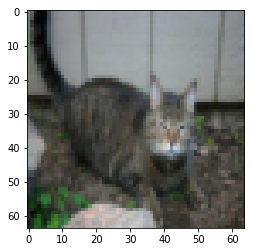

In [5]:
# dataset demo
index = 107 # 0 ~ 208 changable
plt.imshow(train_set_x_orig[index])
print("The label is", str(train_set_y[:, index]) + '.', "This is a", classes[train_set_y[0, index]].decode("utf-8"), "picture")

In [6]:
print("train_set_x_orig:", train_set_x_orig.shape) # (count, width, length, RGB channel)
print("train_set_y_orig:", train_set_y.shape)
print("test_set_x_orig:", test_set_x_orig.shape)
print("test_set_y_orig:", test_set_y.shape)

train_set_x_orig: (209, 64, 64, 3)
train_set_y_orig: (1, 209)
test_set_x_orig: (50, 64, 64, 3)
test_set_y_orig: (1, 50)


In [7]:
# data flatten and transpose
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
print("train_set_x_flatten shape:", train_set_x_flatten.shape) # (pic data, count)
print("test_set_x_flatten shape:", test_set_x_flatten.shape)

train_set_x_flatten shape: (12288, 209)
test_set_x_flatten shape: (12288, 50)


In [8]:
# data normalization
train_set_x = train_set_x_flatten/255 # make all data in range [0, 1]
test_set_x = test_set_x_flatten/255

# 2. Support Function

In [9]:
def sigmoid(z):
    """
    Input:
    z -- a number or array
    
    Output:
    s -- the value after calculation, in [0,1]
    """
    s = 1 / (1 + np.exp(-z))
    return s

In [10]:
def initialize_with_zeros(dim):
    """
    initialize w and b
    
    Input:
    dim -- num of features/weights, 12288 in this case
    
    Output:
    w -- weights matrix
    b -- bias
    """
    w = np.zeros((dim, 1))
    b = 0
    return w, b

In [11]:
def propagate(w, b, X, Y):
    """
    Input:
    w -- weights matrix
    b -- bias
    X -- feature data matrix (12288, 209)
    Y -- label matrix (1, 209)
    
    Output:
    dw -- gradients of weights
    db -- gradients of bias
    cost -- J
    """
    m = X.shape[1] # num of samples
    
    # forward propogation
    A = sigmoid(np.dot(w.T, X) + b)
    cost = np.sum(-Y*np.log(A) - (1-Y)*np.log(1-A)) / m # cost function
    
    # back propogation
    dZ = A - Y
    dw = np.dot(X, dZ.T) / m
    db = np.sum(dZ) / m
    
    grads = {"dw": dw, "db": db}
    return grads, cost

In [12]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    Input:
    w -- weights matrix
    b -- bias
    X -- feature data matrix (12288, 209)
    Y -- label matrix (1, 209)
    num_iterations -- num of iterations
    learning_rate -- learning rate
    print_cost -- when is True, print cost per 100-time iterations
    
    Output:
    w -- weights after optimization
    b -- bias after optimization
    cost_list -- costs per 100-time iterations
    """
    cost_list = []
    
    for i in range(num_iterations):
        grads, cost = propagate(w, b, X, Y) # acquire gradient and cost
        
        dw = grads["dw"]
        db = grads["db"]
        
        # gradient descent
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        if i % 100 == 0:
            cost_list.append(cost)
            if print_cost:
                print("The cost after %i times optimizations is: %f" %(i, cost))
    
    params = {"w": w, "b": b}
    return params, cost_list

In [13]:
def predict(w, b, X):
    """
    Input:
    w -- weights matrix
    b -- bias
    X -- feature data matrix (12288, 209)
    
    Output:
    Y_predict -- prediction matrix (1, 209)
    """
    m = X.shape[1]
    Y_predict = np.zeros((1, m))
    
    A = sigmoid(np.dot(w.T, X) + b)
    
    for i in range(m):
        if A[0,i] > 0.5:
            Y_predict[0,i] = 1
    return Y_predict

# 3. Model Training and Analysis

In [14]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 200, learning_rate = 0.5, print_cost = False):
    w, b = initialize_with_zeros(X_train.shape[0])
    
    params, cost_list = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    w = params["w"]
    b = params["b"]
    
    Y_prediction_train = predict(w, b, X_train)
    Y_prediction_test = predict(w, b, X_test)
    
    print("Accuracy of prediction on train set is: {}%".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("Accuracy of prediction on test set is: {}%".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))
    
    d = {"cost_list": cost_list,
         "Y_prediction_train": Y_prediction_train,
         "Y_prediction_test": Y_prediction_test,
         "w": w,
         "b": b,
         "learning_rate": learning_rate,
         "num_iterations": num_iterations}
    return d

In [15]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

The cost after 0 times optimizations is: 0.693147
The cost after 100 times optimizations is: 0.584508
The cost after 200 times optimizations is: 0.466949
The cost after 300 times optimizations is: 0.376007
The cost after 400 times optimizations is: 0.331463
The cost after 500 times optimizations is: 0.303273
The cost after 600 times optimizations is: 0.279880
The cost after 700 times optimizations is: 0.260042
The cost after 800 times optimizations is: 0.242941
The cost after 900 times optimizations is: 0.228004
The cost after 1000 times optimizations is: 0.214820
The cost after 1100 times optimizations is: 0.203078
The cost after 1200 times optimizations is: 0.192544
The cost after 1300 times optimizations is: 0.183033
The cost after 1400 times optimizations is: 0.174399
The cost after 1500 times optimizations is: 0.166521
The cost after 1600 times optimizations is: 0.159305
The cost after 1700 times optimizations is: 0.152667
The cost after 1800 times optimizations is: 0.146542
The c

The label for this picture is: 1 The prediction is: 1


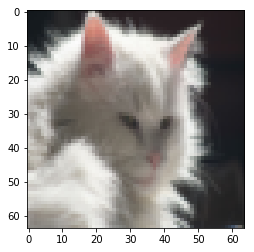

In [16]:
# Recap results
index = 8
plt.imshow(test_set_x[:,index].reshape((64,64,3)))
print("The label for this picture is:", test_set_y[0,index], "The prediction is:", int(d["Y_prediction_test"][0,index]))

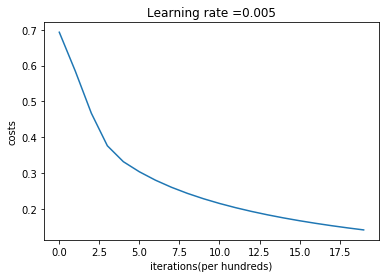

In [17]:
# The change of cost as the number of training increases
costs = np.squeeze(d["cost_list"])
plt.plot(costs)
plt.ylabel("costs")
plt.xlabel("iterations(per hundreds)")
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

Prediction: 1


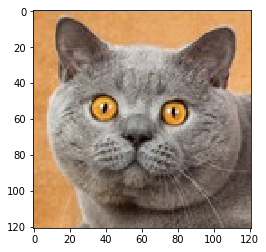

In [18]:
# predict a new image
my_image = "images/sample2.jpg"

image = np.array(plt.imread(my_image))
my_image = tf.resize(image, (64,64), mode="reflect").reshape((1,64*64*3)).T
my_predicted_image = predict(d['w'], d['b'], my_image)

plt.imshow(image)
print("Prediction:", int(np.squeeze(my_predicted_image)))

# 4. Evaluation

Learning rate: 0.01
Accuracy of prediction on train set is: 99.52153110047847%
Accuracy of prediction on test set is: 68.0%

-------------------------------------------------------

Learning rate: 0.001
Accuracy of prediction on train set is: 88.99521531100478%
Accuracy of prediction on test set is: 64.0%

-------------------------------------------------------

Learning rate: 0.0001
Accuracy of prediction on train set is: 68.42105263157895%
Accuracy of prediction on test set is: 36.0%

-------------------------------------------------------



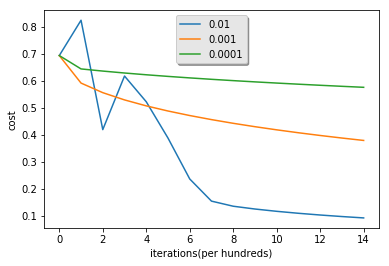

In [19]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}

for i in learning_rates:
    print("Learning rate:", i)
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["cost_list"]), label = str(models[str(i)]["learning_rate"]))

plt.ylabel("cost")
plt.xlabel("iterations(per hundreds)")

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()